In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *
from collections import Counter
import numpy as np
import time

import pandas as pd
import geopandas as gpd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
import matplotlib.ticker as mtick
import matplotlib
import cmocean as cmo

import itertools as it

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
today = time.strftime("%Y-%m-%d")

month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                   4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-06', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATERANGE = DATE_DF['date'].tolist()

date_dict = {DATERANGE[i]:i for i in range(len(DATERANGE))}

In [3]:
fs = 9
wid = 2
lw = 2.5
sta_col = '.2'
nei_col = 'steelblue'
amh_col = '#881c1c'

dates_tt = ['2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
            '2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01']
dates_ll = ['Aug','Sep','Oct','Nov','Dec','2021','Feb','Mar','Apr','May']

pe1 = [path_effects.Stroke(linewidth=1.5,foreground='w'),path_effects.Normal()]
pe2 = [path_effects.Stroke(linewidth=lw*1.5,foreground='w',alpha=0.9),path_effects.Normal()]

In [4]:
dat_shp = gpd.read_file('../../covid19-mobility/data/towns/').rename(columns={'TOWN':'city'})

In [5]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../client_secret.json', scope)
client = gspread.authorize(creds)

mass_data = client.open("COVID-data_Massachusetts")

city_data = mass_data.worksheet('new_town_data')
city_df = pd.DataFrame(city_data.get_all_records(default_blank=np.nan))

amh_df = city_df.loc[city_df['city']=='Amherst'].copy()
amh_df['new_cases_per1000_town'] = amh_df['new_cases_town']/amh_df['population']*1000
amh_df['new_tests_per1000_town'] = amh_df['new_tests_town']/amh_df['population']*1000

amh_neigh = ['Pelham','Belchertown','Sunderland','Leverett','Granby',
             'South Hadley','Hadley','Shutesbury','Hatfield','Northampton',
             'Whately','Easthampton','Holyoke']
amh_neigh = sorted(amh_neigh)

amh_neigh_df = city_df.loc[city_df['city'].isin(amh_neigh)].groupby(['date']).agg({'new_cases_town':'sum',
                                                                                   'new_tests_town':'sum',
                                                                       'population':'sum'}).reset_index()
amh_neigh_df['new_cases_per1000_town'] = amh_neigh_df['new_cases_town']/amh_neigh_df['population']*1000
amh_neigh_df['new_tests_per1000_town'] = amh_neigh_df['new_tests_town']/amh_neigh_df['population']*1000

amh_resto_df = city_df.loc[city_df['city']!='Amherst'].groupby(['date']).agg({'new_cases_town':'sum',
                                                                              'new_tests_town':'sum',
                                                                       'population':'sum'}).reset_index()
amh_resto_df['new_cases_per1000_town'] = amh_resto_df['new_cases_town']/amh_resto_df['population']*1000
amh_resto_df['new_tests_per1000_town'] = amh_resto_df['new_tests_town']/amh_resto_df['population']*1000

In [6]:
printtown = '(Belchertown, Easthampton,\n'+\
            ' Granby, Hadley, Hatfield,\n'+\
            ' Holyoke, Leverett,\n'+\
            ' Northampton, Pelham,\n'+\
            ' Shutesbury, South Hadley,\n'+\
            ' Sunderland, and Whately)'

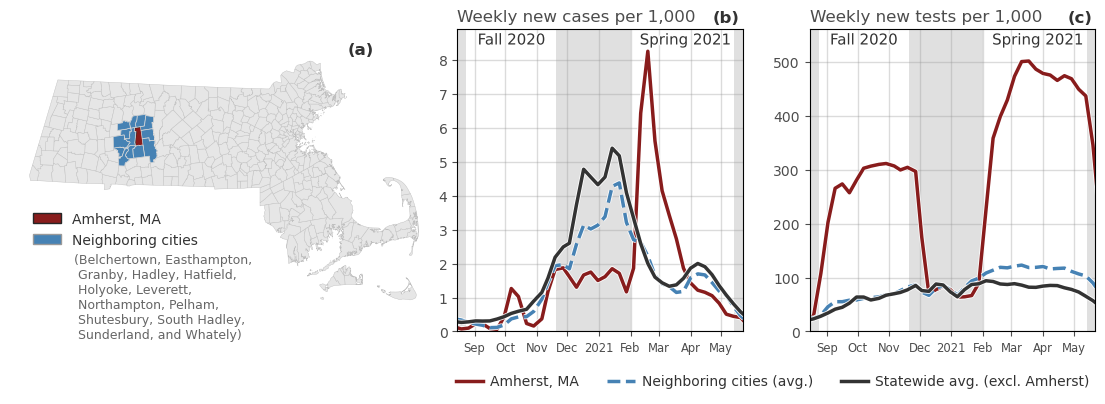

In [13]:
fig, ax = plt.subplots(1,4,figsize=(14,4),dpi=100,
                       gridspec_kw={'width_ratios':[1.5,1,0.1,1]})
plt.subplots_adjust(wspace=0.075)

################### MAP FIG #####################
dat_shp.plot(ax=ax[0], fc='.9', ec='.75', lw=0.3)
dat_shp.loc[dat_shp['city']=='AMHERST'].plot(ax=ax[0], fc=amh_col, ec='.15',
                                             lw=0.5, label='Amherst', legend=True)
dat_shp.loc[dat_shp['city'].isin([i.upper() for i in amh_neigh])].plot(ax=ax[0],
                               fc=nei_col, ec='.85', lw=0.5, label='neighboring towns')
ax[0].set_axis_off()
legend_elements = [Patch(facecolor=amh_col, edgecolor='.15',
                         label='Amherst, MA'),
                   Patch(facecolor=nei_col, edgecolor='.6',
                         label='Neighboring cities')]
l = ax[0].legend(handles=legend_elements, loc='lower left',
                 bbox_to_anchor=[0.025, 0.2], framealpha=0)
for text in l.get_texts():
    text.set_color('.2')

ax[0].text(0.15, 0.225, printtown, transform=ax[0].transAxes, fontsize=9,
           ha='left', va='top', color='.4')
################### MAP FIG #####################


ax[1].plot([date_dict[i] for i in amh_df['date']],
           amh_df['new_cases_per1000_town'].rolling(window=wid).mean(),
           label='Amherst, MA', color=amh_col, lw=lw, linestyle="-",
           path_effects=pe2)
ax[1].plot([date_dict[i] for i in amh_neigh_df['date']],
           amh_neigh_df['new_cases_per1000_town'].rolling(window=wid).mean(),
           label='Neighboring cities (avg.)', color=nei_col, lw=lw,
           linestyle='--', path_effects=pe2)
ax[1].plot([date_dict[i] for i in amh_resto_df['date']],
           amh_resto_df['new_cases_per1000_town'].rolling(window=wid).mean(),
           label='Statewide avg. (excl. Amherst)', color=sta_col, lw=lw,
           linestyle="-", path_effects=pe2)

ax[-1].plot([date_dict[i] for i in amh_df['date']],
            amh_df['new_tests_per1000_town'].rolling(window=wid).mean(),
            label='Amherst, MA', color=amh_col, lw=lw,
            linestyle='-', path_effects=pe2)
ax[-1].plot([date_dict[i] for i in amh_neigh_df['date']],
            amh_neigh_df['new_tests_per1000_town'].rolling(window=wid).mean(),
            label='Neighboring cities (avg.)', color=nei_col, lw=lw,
            linestyle='--', path_effects=pe2)
ax[-1].plot([date_dict[i] for i in amh_resto_df['date']],
            amh_resto_df['new_tests_per1000_town'].rolling(window=wid).mean(),
            label='Statewide avg.\n(excl. Amherst)', color=sta_col, lw=lw,
            linestyle='-', path_effects=pe2)

ax[1].set_ylim(0, 8.9)
ax[-1].set_ylim(0, 560)
ax[1].set_title('Weekly new cases per 1,000', x=0,color='.3',ha='left')
ax[-1].set_title('Weekly new tests per 1,000', x=0,color='.3',ha='left')

l = ax[1].legend(loc=3, ncol=3, bbox_to_anchor=[-0.05, -0.23], framealpha=0, handletextpad=0.5)
for text in l.get_texts():
    text.set_color('.2')



letts = ['(a)','(b)','','(c)']
for ai,a in enumerate(fig.axes):
    if ai == 2:
        continue
    if ai>0:
        ylimi = a.get_ylim()[1]
        a.fill_between([date_dict['2020-08-24'], date_dict['2020-08-15']], -1, ylimi,
                       color='.7', alpha=0.4, zorder=0, lw=0)
        a.fill_between([date_dict['2021-05-14'], date_dict['2021-05-22']], -1, ylimi,
                       color='.7', alpha=0.4, zorder=0, lw=0)
        a.fill_between([date_dict['2020-11-20'], date_dict['2021-02-01']], -1, ylimi,
                       color='.7', alpha=0.4, zorder=0, lw=0)
        
        a.text(0.19, 0.99,'Fall 2020',ha='center',va='top',fontsize=fs*1.2,
               color='.2',path_effects=pe1, transform=a.transAxes)
        a.text(0.80, 0.99,'Spring 2021',ha='center',va='top',fontsize=fs*1.2,
               color='.2',path_effects=pe1, transform=a.transAxes)
        
        a.tick_params(labelcolor='.3', color='.3')
        a.grid(linewidth=1.0, color='.6', alpha=0.35)
        a.text(0.99, 1.015, letts[ai], ha='right', va='bottom', transform=a.transAxes,
               fontweight='bold', fontsize='large', color='.2')
        a.set_xticks([date_dict[i] for i in dates_tt])
        a.set_xticklabels(dates_ll, fontsize='small')
        a.set_ylim(0, ylimi)
        a.set_xlim(date_dict['2020-08-15'],date_dict['2021-05-22'])

    else:
        a.text(0.85, 0.97, letts[ai], ha='right', va='bottom', transform=a.transAxes,
               fontweight='bold', fontsize='large', color='.2')

ax[2].set_axis_off()

plt.savefig('../figs/pngs/amherst_map_cases_tests_x1.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/amherst_map_cases_tests_x1.pdf',bbox_inches='tight')

plt.show()